In [ ]:
pip install tf-nightly

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, concatenate, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load model

In [ ]:
mixed_data_model=tf.keras.models.load_model("mdm100.h5")

# Load mixed data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open(r"/content/drive/MyDrive/Project aprendizagem automatica avançada/Xcnn1867.pkl", 'rb') as fp: #Images non augm
        Ximg = pickle.load(fp)
fp.close()

with open(r"/content/drive/MyDrive/Project aprendizagem automatica avançada/guess_inputs.pkl", 'rb') as fp: #data
        Xdat = pickle.load(fp)
fp.close()
with open(r"/content/drive/MyDrive/Project aprendizagem automatica avançada/1867_labels.pkl", 'rb') as fp:
        y = pickle.load(fp)
fp.close()


In [ ]:
for i in range(len(y)):
  y[i][2]=y[i][2]/1000

In [ ]:
scaler = MinMaxScaler()
scaler.fit(y)
y=scaler.transform(y)

In [ ]:
Xdat=np.array(Xdat)
Ximg=np.array(Ximg)
y=np.array(y)

In [ ]:
X_trainCNN, X_valCNN,X_trainANN,X_valANN, y_train, y_val = train_test_split(Ximg,Xdat, y, test_size=0.2, random_state=1)
#X_trainANN, X_valANN=Xdat[:len(X_trainCNN)],Xdat[-1:]

# Mixed data model

## Load model

In [ ]:
inputCNN = Input(shape=(180, 180, 3))
inputANN = Input(shape=(3,))

In [ ]:
cnn1 = keras.Sequential([
        Conv2D(9, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(45, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(90, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(100, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(200, activation='relu'),
])

In [ ]:
guess_ANN = keras.Sequential([
    Dense(units=50, activation="relu"),
    Dense(units=100, activation="relu"),
    Dense(units=200, activation="relu"),
    ]
)

In [ ]:
branchCNN=cnn1(inputCNN)
mixed_cnn=Model(inputs=inputCNN, outputs=branchCNN)

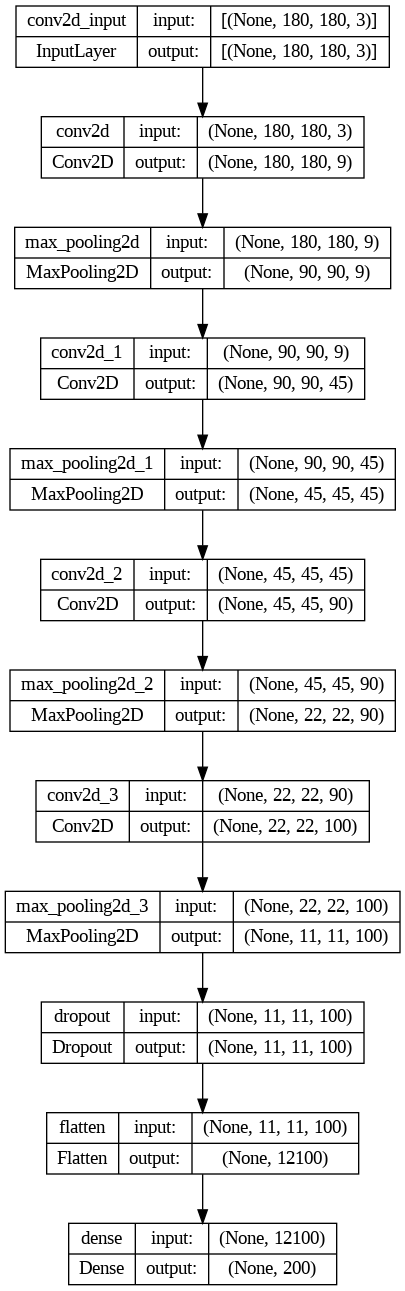

In [ ]:
plot_model(cnn1, to_file='mixed_cnn.png', show_shapes=True, show_layer_names=True)

In [ ]:
branchANN=guess_ANN(inputANN)
mixed_ann=Model(inputs=inputANN, outputs=branchANN)

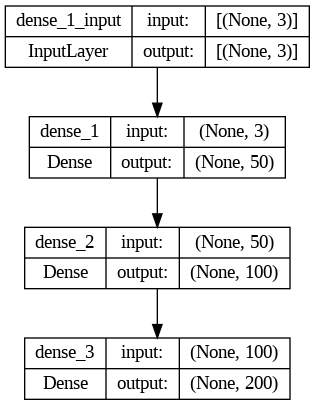

In [ ]:
plot_model(guess_ANN, to_file='mixed_ann.png', show_shapes=True, show_layer_names=True)

In [ ]:
combined = concatenate([mixed_cnn.output, mixed_ann.output])
final_branch_in = Dense(300, activation="relu")(combined)
final_branch_h1 = Dense(50, activation="relu")(final_branch_in)
final_branch_out = Dense(3, activation="relu")(final_branch_h1)

In [ ]:
mixed_data_model=Model(inputs=[mixed_cnn.input, mixed_ann.input], outputs=final_branch_out)

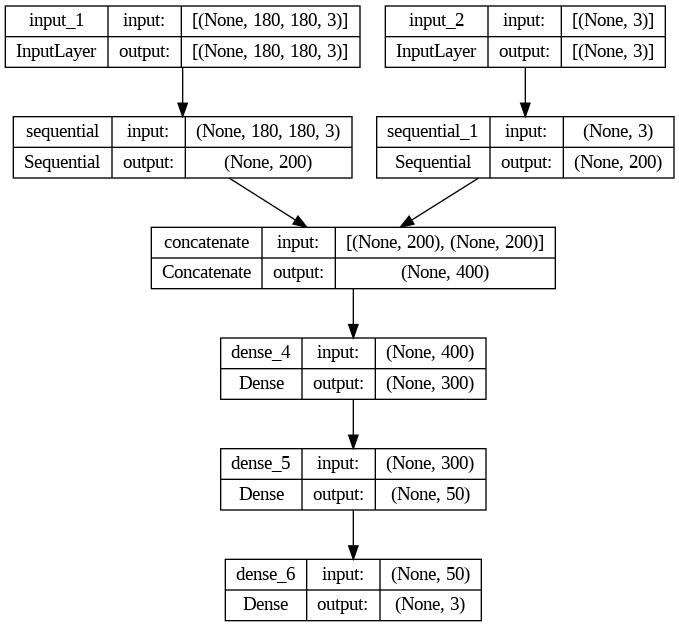

In [ ]:
plot_model(mixed_data_model, to_file='mixed_data_model.png', show_shapes=True, show_layer_names=True)

## Training and results

In [ ]:
mixed_data_model.compile(loss="mean_squared_error",optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
history=mixed_data_model.fit(x=[X_trainCNN,X_trainANN],y=y_train,epochs=100,validation_data=([X_valCNN,X_valANN],y_val),verbose=0,shuffle=True,batch_size=400)

In [ ]:
plt.plot(history.history['val_loss'],"k")
plt.plot(history.history['loss'],"b")
#plt.plot(score,"r")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['val_loss'],"k",label="Validation")
plt.plot(history.history['loss'],"b",label="Training")
plt.title('Mixed data model mean squared error for augmented data')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.show()

In [ ]:
test3=np.expand_dims(y_val[0],axis=0)

In [ ]:
test1=np.expand_dims(X_valCNN[0],axis=0)
test2=np.expand_dims(X_valANN[0],axis=0)
test1.shape
test2.shape
scaler.inverse_transform(mixed_data_model.predict([test1,test2]))

1/1 [==============================] - 0s 257ms/step


array([[2.0466201, 1.2398828, 2.7146122]], dtype=float32)

In [ ]:
print("Predict=",scaler.inverse_transform(mixed_data_model.predict([test1,test2])),"Real=",scaler.inverse_transform(test3))

1/1 [==============================] - 0s 37ms/step
Predict= [[2.0466201 1.2398828 2.7146122]] Real= [[2.14358936 1.15       2.58226019]]


In [ ]:
pred=[]
true=[]
for i in range(len(X_valCNN)):
  test1=np.expand_dims(X_valCNN[i],axis=0)
  test2=np.expand_dims(X_valANN[i],axis=0)
  pred.append(scaler.inverse_transform(mixed_data_model.predict([test1,test2],verbose=0)))
  true.append((scaler.inverse_transform([y_val[i]])))

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(true, pred).numpy()

0.16742623

In [ ]:
truee=np.squeeze(true, 1)
predd=np.squeeze(pred, 1)

In [ ]:
r2=tf.keras.metrics.R2Score()
r2.update_state(truee, predd)
result = r2.result()
result.numpy()  

0.7609337

In [ ]:
#mixed_data_model.save("mdm.h5")